In [2]:
import pandas as pd
import sys
sys.path.append("..")
from src.Utils import get_ents_spans

data = pd.read_parquet("../data/dataset/shs100k2/data.parquet").reset_index()


# Overview

In [3]:
data_spans = pd.DataFrame(pd.json_normalize(data.IOB.apply(get_ents_spans)))
data["WoA"] = data_spans.WoA
data.WoA = data.WoA.apply(lambda x: x if x == x else [])
data["Artist"] = data_spans.Artist
data.Artist = data.Artist.apply(lambda x: x if x == x else [])

data["WoA_count"] = data.WoA.apply(len)
data["Artist_count"] = data.Artist.apply(len)
data["WoA_missing"] = data.WoA_count == 0
data["Artist_missing"] = data.Artist_count == 0
data["WoA_first"] = data.WoA.apply(lambda x: x[0] if len(x) > 0 else None)
data["Artist_first"] = data.Artist.apply(lambda x: x[0] if len(x) > 0 else None)
data["WoA_len"] = data.WoA_first.apply(lambda x: x[1] + 1 - x[0] if isinstance(x, tuple) else None)
data["Artist_len"] = data.Artist_first.apply(lambda x: x[1] + 1 - x[0] if isinstance(x, tuple) else None)
data["WoA_start"] = data.WoA_first.apply(lambda x: x[0] if x else None)
data["Artist_start"] = data.Artist_first.apply(lambda x: x[0] if x else None)


# Annotated Dataset

In [4]:
data_annot = data.loc[~data.IOB_human.isna()]
data_annot.loc[:,
    ["split", "set_id", "yt_id", "WoA_count", "Artist_count", 
     "WoA_len", "Artist_len", "WoA_missing", "Artist_missing",
     "WoA_start", "Artist_start"]
    ].groupby("split").agg(
        {"set_id": pd.Series.nunique, "yt_id": "count", 
         "WoA_count": ["min", "median", "max"], "Artist_count": ["min", "median", "max"],
         "WoA_missing": "sum", "Artist_missing": "sum",
         "WoA_len": ["min", "median", "max"], "Artist_len": ["min", "median", "max"],
         "WoA_start": "median", "Artist_start": "median"
         }
    )


set_id yt_id WoA_count            Artist_count            WoA_missing  \
      nunique count       min median max          min median max         sum   
split                                                                          
TEST      179   203         0    1.0   3            0    1.0   4          12   
TRAIN     194   208         0    1.0   3            0    1.0   3          13   
VAL       190   202         0    1.0   3            0    1.0   4          10   

      Artist_missing WoA_len              Artist_len             WoA_start  \
                 sum     min median   max        min median  max    median   
split                                                                        
TEST              48     1.0    3.0  12.0        1.0    2.0  7.0       2.0   
TRAIN             53     1.0    3.0  10.0        1.0    2.0  6.0       3.0   
VAL               43     1.0    3.0  15.0        1.0    2.0  9.0       2.0   

      Artist_start  
            median  
split               
TEST           0.0  
TRAIN          0.0  
VAL            0.0

In [5]:
data_annot.agg(
        {"set_id": pd.Series.nunique, "yt_id": "count", 
         "WoA_count": ["min", "median", "max"], "Artist_count": ["min", "median", "max"],
         "WoA_missing": "sum", "Artist_missing": "sum",
         "WoA_len": ["min", "median", "max"], "Artist_len": ["min", "median", "max"],
         "WoA_start": "median", "Artist_start": "median"
         }
    )


,set_id,yt_id,WoA_count,Artist_count,WoA_missing,Artist_missing,WoA_len,Artist_len,WoA_start,Artist_start
nunique,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
count,NaN,613.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,0.0,0.0,NaN,NaN,1.0,1.0,NaN,NaN
median,NaN,NaN,1.0,1.0,NaN,NaN,3.0,2.0,2.0,0.0
max,NaN,NaN,3.0,4.0,NaN,NaN,15.0,9.0,NaN,NaN
sum,NaN,NaN,NaN,NaN,35.0,144.0,NaN,NaN,NaN,NaN


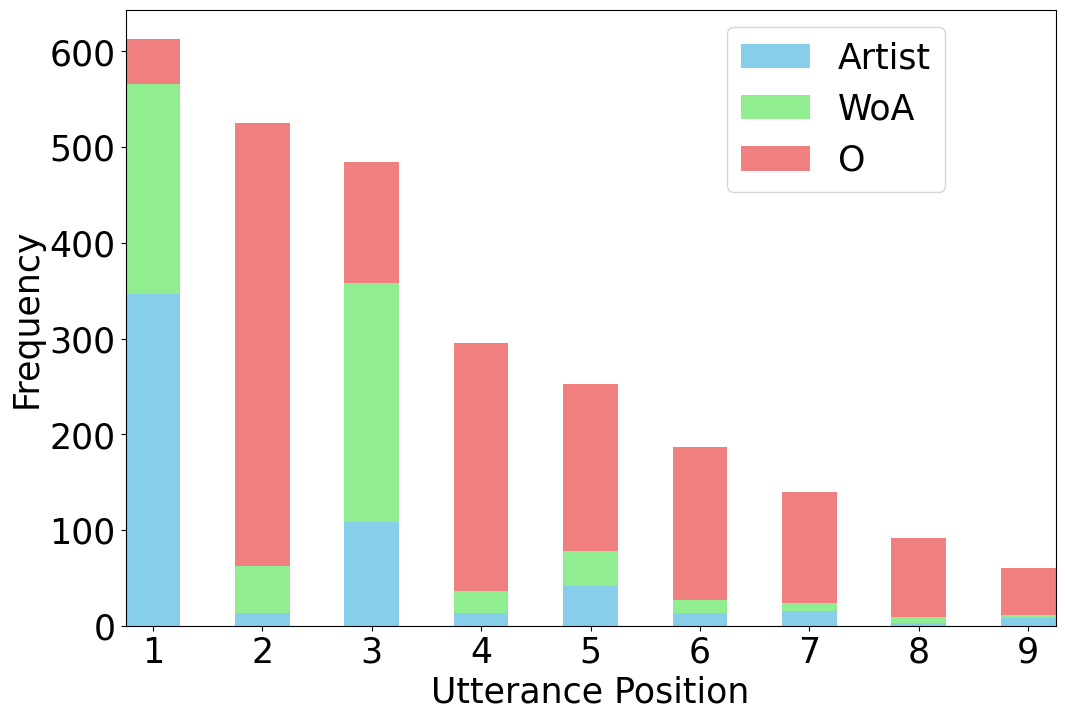

In [6]:
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

def transform_iob_tags(tag_list):
    transformed = []
    for tag in tag_list:
        if tag.startswith('B-') or tag.startswith('I-'):
            class_type = tag.split('-')[1]
            # Add the class_type only if it's not the same as the last appended class_type
            if not transformed or transformed[-1] != class_type:
                transformed.append(class_type)
        else:
            transformed.append("O")
    return transformed

cls_utts = data_annot.IOB_human.apply(transform_iob_tags)

mention_order_counts = defaultdict(Counter)

# Populate the mention order counts
for class_list in cls_utts:
    for idx, class_type in enumerate(class_list):
        mention_order_counts[idx + 1][class_type] += 1  # idx + 1 because we want 1-based index

# Convert the mention order counts to a DataFrame for easier plotting
mention_order_df = pd.DataFrame(mention_order_counts).fillna(0)

# Plotting
# Plotting
ax = mention_order_df.T.plot(kind='bar', 
                             stacked=True, 
                             figsize=(12, 8), 
                             color=['skyblue', 'lightgreen', 'lightcoral', 'orange', 'purple', 'lightgray'])

# Customize the plot
plt.xlabel('Utterance Position', fontsize=25)
plt.ylabel('Frequency', fontsize=25)
#plt.title('Frequency of Class Types by Mention Order', fontsize=25)
plt.xticks(rotation=0, fontsize=25)  # Make x-ticks horizontal and increase font size
plt.yticks(fontsize=25)  #


plt.xlim(-0.25, 8.25)  # Adjust xlim to fit all mention orders
#plt.title('Frequency of Class Types by Mention Order')

plt.legend(title='', loc='upper right', bbox_to_anchor=(0.9, 1), fontsize=25)

# Save the plot to a file
plt.savefig("../figures/utterance_positions.pdf")

# Show the plot
plt.show()


In [5]:
data_annot.WoA_count.sum() + data_annot.Artist_count.sum()


1233

/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


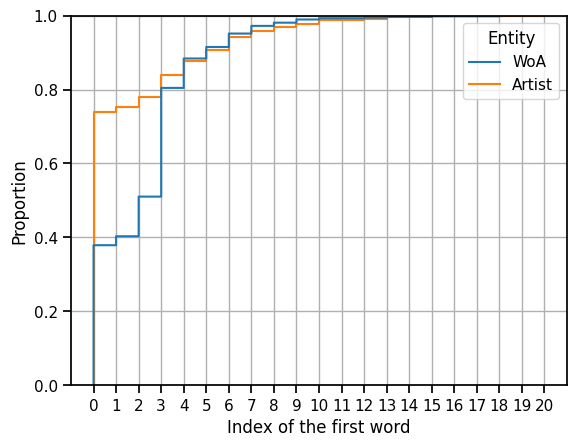

In [7]:
__data = pd.melt(
        data_annot[["yt_id", "WoA_start", "Artist_start"]].rename(
            columns={"WoA_start": "WoA", "Artist_start": "Artist"}),
        var_name="Entity", id_vars="yt_id", value_vars=["WoA", "Artist"])

sns.ecdfplot(
    __data,
    x="value",
    hue="Entity"

)

plt.xticks(range(int(__data['value'].min()), int(__data['value'].max()) + 1))

# Add gridlines
plt.grid(True)
plt.xlabel("Index of the first word")
plt.savefig("../figures/cdf_start_index.pdf")
plt.show()


# Music Utterance Collection

In [9]:
data_utts = data[data.IOB_human.isna()]

data_utts.WoA_count.sum() + data_utts.Artist_count.sum()


176728

In [10]:
data_utts.title.apply(lambda x: x[0]).nunique() + data_utts.performer.apply(lambda x: x[0] if len(x) > 0 else 0).nunique()


42786

In [11]:
data["WoA_utterance"] = data.apply(
    lambda x: [' '.join(x.TEXT[span[0]:span[1]+1]) for span in x.WoA], axis=1)
data["Artist_utterance"] = data.apply(
    lambda x: [' '.join(x.TEXT[span[0]:span[1]+1]) for span in x.Artist], axis=1)



In [12]:
data[["set_id", "title", "WoA_utterance"]].explode("title").explode("WoA_utterance").groupby(
    ["set_id", "title"]
).agg(list)



WoA_utterance
set_id title                                                         
0       Summertime                            [nightmare, summertime]
        [Summertime]                                            [nan]
       6                                            [6, 8 summertime]
       8 Summertime                                 [6, 8 summertime]
       A Change Is Gonna Come    [a change is gonna come, summertime]
...                                                               ...
9992   Vous permettez, Madame?                [vous permettez madame]
       Vous permettez, Monsieur             [vous permettez monsieur]
9993   53rd & 3rd                       [53rd & 3rd, nan, 53rd & 3rd]
9994   Sytten ti                                          [sytten ti]
9998   I Don't Care                        [i dont care, i dont care]

[21522 rows x 1 columns]

In [13]:
data[["set_id", "ver_id", "yt_id", "title", "WoA_utterance"]]


,set_id,ver_id,yt_id,title,WoA_utterance
0,21,1,gORyrU1xQpg,[Yesterday],[yesterday]
1,21,2,jQhC3bMMLmw,[Yesterday],[yesterday]
2,21,5,eI3-EVEU51s,[Yesterday],[yesterday]
3,21,6,ew1y-gvO_NM,[Yesterday],[yesterday]
4,21,7,tjYQuEyxRp0,[Yesterday],[yesterday]
...,...,...,...,...,...
89758,5980,5,2S3cauISpNw,"[Give Me Love (Give Me Peace on Earth), Give M...",[give me love ( give me peace on earth]
89759,5982,0,Q6ix7lWPDAQ,[I Ain't Living Long Like This],[aint living long like this]
89760,5982,2,0JP_ZipG5Z0,[Ain't Living Long Like This],[aint living long like this]
89761,5982,5,j7MC3ckUaDA,[I Ain't Living Long Like This],[aint living long like this]


# Full Dataset

In [14]:
data[["set_id", "yt_id", "WoA_count", "Artist_count", 
                   "WoA_len", "Artist_len", "WoA_missing", "Artist_missing",
                   "WoA_start", "Artist_start"]].agg(
    {
        "set_id": pd.Series.nunique, 
        "yt_id": "count", 
        "WoA_count": ["min", "max"], 
        "Artist_count": ["min", "max"],
        "WoA_missing": "sum", 
        "Artist_missing": "sum",
        "WoA_len": ["median", "max"], 
        "Artist_len": ["median", "max"],
        "WoA_start": "median", 
        "Artist_start": "median"
    }
).max()


set_id             8836.0
yt_id             89763.0
WoA_count             5.0
Artist_count          7.0
WoA_missing        4539.0
Artist_missing     7689.0
WoA_len              19.0
Artist_len           10.0
WoA_start             3.0
Artist_start          0.0
dtype: float64

In [15]:
data[
    ["split", "set_id", "yt_id", "WoA_count", "Artist_count", 
     "WoA_len", "Artist_len", "WoA_missing", "Artist_missing",
     "WoA_start", "Artist_start"]
    ].groupby("split").agg(
        {"set_id": pd.Series.nunique, "yt_id": "count", 
         "WoA_count": ["min", "max"], "Artist_count": ["min", "max"],
         "WoA_missing": "sum", "Artist_missing": "sum",
         "WoA_len": ["median", "max"], "Artist_len": ["median", "max"],
         "WoA_start": "median", "Artist_start": "median"
         }
    )


set_id  yt_id WoA_count     Artist_count     WoA_missing  \
      nunique  count       min max          min max         sum   
split                                                             
TEST     1679   8811         0   3            0   6         332   
TRAIN    5321  71904         0   5            0   7        3802   
VAL      1838   9048         0   3            0   4         405   

      Artist_missing WoA_len       Artist_len       WoA_start Artist_start  
                 sum  median   max     median   max    median       median  
split                                                                       
TEST             739     3.0  16.0        2.0  10.0       3.0          0.0  
TRAIN           6200     3.0  19.0        2.0   9.0       3.0          0.0  
VAL              750     3.0  16.0        2.0   9.0       3.0          0.0

In [16]:
data.agg(
        {"set_id": pd.Series.nunique, "yt_id": "count", 
         "WoA_count": ["min", "median", "max"], "Artist_count": ["min", "median", "max"],
         "WoA_missing": "sum", "Artist_missing": "sum",
         "WoA_len": ["min", "median", "max"], "Artist_len": ["min", "median", "max"],
         "WoA_start": "median", "Artist_start": "median"
         }
    )


,set_id,yt_id,WoA_count,Artist_count,WoA_missing,Artist_missing,WoA_len,Artist_len,WoA_start,Artist_start
nunique,8836.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
count,NaN,89763.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,0.0,0.0,NaN,NaN,1.0,1.0,NaN,NaN
median,NaN,NaN,1.0,1.0,NaN,NaN,3.0,2.0,3.0,0.0
max,NaN,NaN,5.0,7.0,NaN,NaN,19.0,10.0,NaN,NaN
sum,NaN,NaN,NaN,NaN,4539.0,7689.0,NaN,NaN,NaN,NaN


In [17]:
len(data_annot)

613

# Automatic vs. Human Annotations

In [18]:
data = data.dropna(subset="IOB_human")


In [19]:
from src.Eval import compute_results


compute_results(data.IOB_human, data.IOB_auto)


2024-08-28 13:44:47 root INFO: Imported 613 predictions for 613 true examples



 Overall
schema      precision    recall        f1    correct    incorrect    partial    missed    spurious    possible    actual
--------  -----------  --------  --------  ---------  -----------  ---------  --------  ----------  ----------  --------
strict       0.924812  0.498783  0.648051        615           32          0       586          18        1233       665
ent_type     0.969925  0.523114  0.679663        645            2          0       586          18        1233       665
exact        0.92782   0.500406  0.650158        617           30          0       586          18        1233       665

 Artist
schema      precision    recall        f1    correct    incorrect    partial    missed    spurious    possible    actual
--------  -----------  --------  --------  ---------  -----------  ---------  --------  ----------  ----------  --------
strict       0.919308  0.538851  0.679446        319           15          0       258          13         592       347
ent_type     

{'overall_strict_precision_micro': 0.924812030075188,
 'overall_strict_recall_micro': 0.49878345498783455,
 'overall_strict_f1_micro': 0.6480505795574288,
 'overall_strict_correct_micro': 615,
 'overall_strict_incorrect_micro': 32,
 'overall_strict_partial_micro': 0,
 'overall_strict_missed_micro': 586,
 'overall_strict_spurious_micro': 18,
 'overall_strict_possible_micro': 1233,
 'overall_strict_actual_micro': 665,
 'overall_ent_type_precision_micro': 0.9699248120300752,
 'overall_ent_type_recall_micro': 0.5231143552311436,
 'overall_ent_type_f1_micro': 0.6796628029504742,
 'overall_ent_type_correct_micro': 645,
 'overall_ent_type_incorrect_micro': 2,
 'overall_ent_type_partial_micro': 0,
 'overall_ent_type_missed_micro': 586,
 'overall_ent_type_spurious_micro': 18,
 'overall_ent_type_possible_micro': 1233,
 'overall_ent_type_actual_micro': 665,
 'overall_exact_precision_micro': 0.9278195488721804,
 'overall_exact_recall_micro': 0.5004055150040552,
 'overall_exact_f1_micro': 0.6501580